In [1]:
from jax import config
import jax.numpy as np
import webbpsf
import matplotlib.pyplot as plt
import dLux as dl
from optics import NIRISSOptics, find_wavelengths, find_diameter

config.update("jax_enable_x64", True)
plt.rcParams["image.origin"] = 'lower'

ModuleNotFoundError: No module named 'webbpsf'

In [2]:
def plot_and_compare(PSF1, PSF2, titles=None, pixel_crop: int=None, save_fig: bool = False):

    if titles is None:
        titles = ['WebbPSF $\sqrt{PSF}$', r'$\partial$Lux $\sqrt{PSF}$']

    if pixel_crop is not None:
        PSF1 = PSF1[pixel_crop:-pixel_crop, pixel_crop:-pixel_crop]
        PSF2 = PSF2[pixel_crop:-pixel_crop, pixel_crop:-pixel_crop]

    fig, ax = plt.subplots(1, 3, figsize=(10.5, 4))
    fig.subplots_adjust(left=0.02, right=0.98, top=0.8, bottom=0.2)
    ticks = [0, PSF1.shape[0]-1]
    # WebbPSF PSF
    c0 = ax[0].imshow(PSF1**.5, cmap='magma')
    ax[0].set(title=titles[0], xticks=ticks, yticks=ticks)
    # fig.colorbar(c0, label='Relative Intensity')

    # dLux PSF
    c1 = ax[1].imshow(PSF2**.5, cmap='magma')
    ax[1].set(title=titles[1], xticks=ticks, yticks=ticks)
    # fig.colorbar(c1, label='Relative Intensity')

    # Residuals
    residuals = PSF1 - PSF2
    bounds = np.array([-residuals.min(), residuals.max()])
    c2 = ax[2].imshow(residuals, cmap='seismic',
                      vmin=-bounds.max(), vmax=bounds.max())
    ax[2].set(title=f'Residuals', xticks=ticks, yticks=ticks)
    fig.colorbar(c2, label='Residual')

    if save_fig: plt.savefig('psfs.pdf', dpi=400, bbox_inches='tight')
    plt.show()

# NIRISS dLux Model - Ignoring Detector Effects
First lets model the PSFs ignoring detector effects. We will consider only the aperture and the field dependent aberrations.

## Model PSF from WebbPSF

In [3]:
# creating NIRISS object
NIRISS = webbpsf.NIRISS()

# updating NIRISS configuration
NIRISS.filter = 'F480M'
NIRISS.pupil_mask = 'MASK_NRM'
psfs = NIRISS.calc_psf()  # calculating fits files
webbpsfpsf = psfs[0].data  # PSF Array from WebbPSF

## Model PSF from dLux

In [4]:
# creating dLux optics
optics = NIRISSOptics()

# Generating PSF with dLux
wavels, weights = find_wavelengths(psfs[0])  # finding wavelengths and spectral weights
dluxpsf = optics.propagate(np.array(wavels), weights=np.array(weights))

ValueError: Must specify either radial_orders or noll_indices

## Comparing PSFs
As you can see, they match to machine precision.

In [ ]:
plot_and_compare(webbpsfpsf, dluxpsf)

# NIRISS dLux Model - Including Detector Effects
## WebbPSF
Using `psfs[2]` now...

In [6]:
webbpsfdetpsf = psfs[2].data  # PSF Array from WebbPSF

## dLux

In [7]:
from detector_layers import DistortionFromSiaf, ApplyBFE
from dLux.utils import deg_to_rad as d2r

In [8]:
# baseline = 0.
NIS_CEN_aperture = NIRISS.siaf.apertures['NIS_CEN']

# Construct Detector
detector = dl.LayeredDetector([
    # dl.ApplyJitter(sigma=1.5),  # Gaussian Jitter
    dl.detector_layers.RotateDetector(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle")), order=3),  # Rotates PSF by half a degree
    DistortionFromSiaf(aperture=NIS_CEN_aperture),  # Wavefront sphere to wavefront plane
    # dl.IntegerDownsample(kernel_size=oversample),  # Downsample to detector pixel scale
    # ApplyBFE(1e-6),  # Apply BFE
    # dl.AddConstant(baseline),  # Add baseline
])

source = dl.PointSource(wavelengths=wavels, weights=weights)
instrument = dl.Instrument(optics=optics, sources=source, detector=detector)

dluxdetpsf = instrument.model()

## Comparing PSFs with Detector Effects
This should match WebbPSF within machine precision if using cubic spline interpolation in the rotation, and we ignore edge effects.

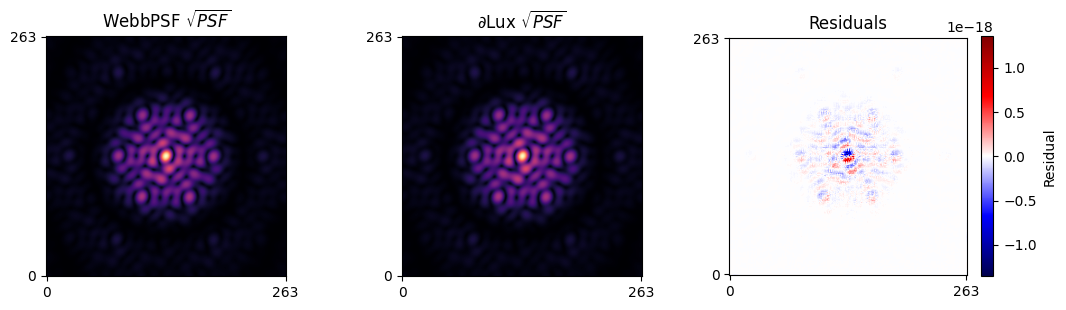

In [9]:
plot_and_compare(webbpsfdetpsf, dluxdetpsf, pixel_crop=20)

# Generating Hexike Bases
We want to generate a Zernike basis for each mirror segment (or in this case, Hexike basis) to use for phase retrieval later.

In [10]:
from bases import jwst_hexike_bases
from webbpsf import constants as const

In [11]:
def plot_bases(bases, mask, npix, pscale, save=False, edges=False):
    sample_bases = bases.sum(0) * mask
    fig, ax = plt.subplots(2, 5, figsize=(12.5, 5))

    fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0., hspace=0.)
    for i in range(2):
        for j in range(5):
            bound = np.array([sample_bases[i * 5 + j].max(), -sample_bases[i * 5 + j].min()]).max()
            ax[i, j].imshow(sample_bases[i * 5 + j],
                            cmap='seismic',
                            vmin=-bound,
                            vmax=bound,
                            extent=(pscale * -npix / 2, pscale * npix / 2, pscale * -npix / 2, pscale * npix / 2)
                            )

            ax[i, j].set(xticks=[], yticks=[])

            if edges:
                corners = const.JWST_PRIMARY_SEGMENTS
                for segment in corners:
                    corner = segment[1].T
                    ax[i, j].plot(corner[0], corner[1], marker='', c='k', alpha=0.5, linestyle='--')

    if save:
        plt.savefig('hexike_bases.pdf', dpi=1000)
    plt.show()
    return

## Full Pupil

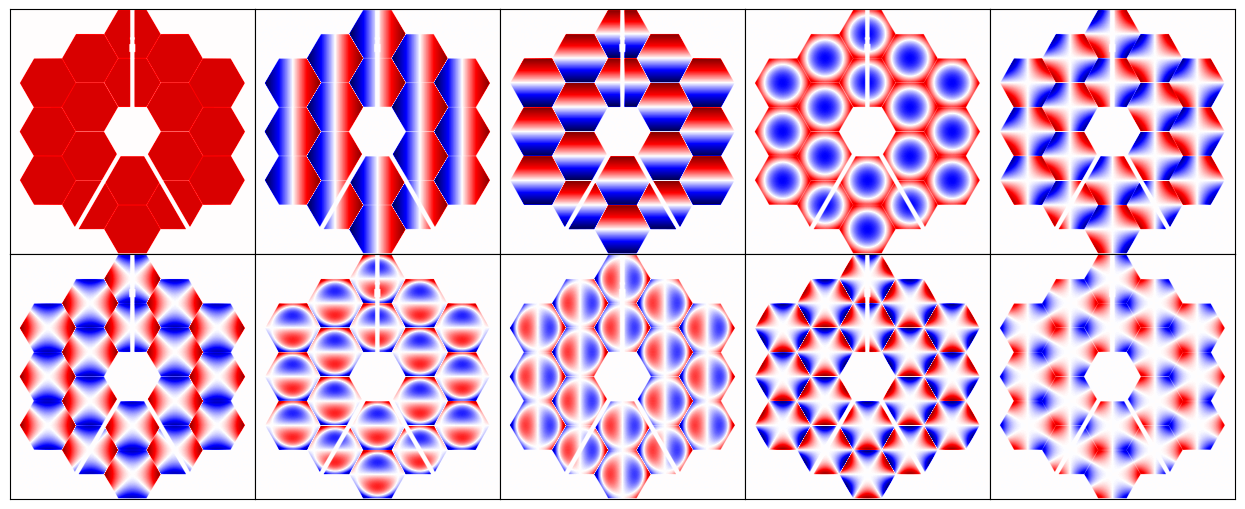

In [12]:
npix = 1024

bases, mask, pscale = jwst_hexike_bases(npix=npix, AMI=False)
plot_bases(bases, mask, npix, pscale)

## AMI Pupil

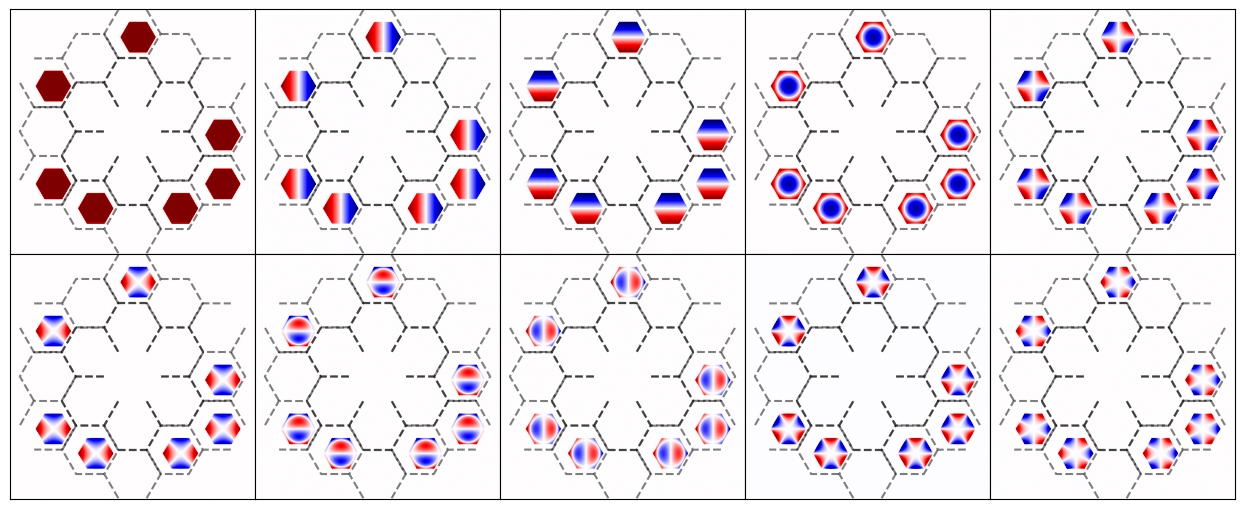

In [13]:
AMI_bases, AMI_mask, pscale = jwst_hexike_bases(npix=npix, AMI=True)
plot_bases(AMI_bases, AMI_mask, npix, pscale, edges=True)